**All the code mentioned in this file works fine, at many cells I've deleted outputs for privacy purpose.** 

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import emoji
from collections import Counter

### This project is performed in Google Colab & File is imported from Google Drive hence some additional lines here

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!ls "/content/drive/My Drive/Whatsapp"

## Data Preprocessing

In [4]:
def rawToDf(file, key):
    split_formats = {
        '12hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s[APap][mM]\s-\s',
        '24hr' : '\d{1,2}/\d{1,2}/\d{2,4},\s\d{1,2}:\d{2}\s-\s',
        'custom' : ''
    }
    datetime_formats = {
        '12hr' : '%d/%m/%Y, %I:%M %p - ',
        '24hr' : '%d/%m/%Y, %H:%M - ',
        'custom': ''
    }
    
    with open('/content/drive/My Drive/Whatsapp/WhatsApp Chat with XYZ.txt', 'r', encoding = "utf-8") as raw_data:
        raw_string = ' '.join(raw_data.read().split('\n')) # converting the list split by newline char. as one whole string as there can be multi-line messages
        user_msg = re.split(split_formats[key], raw_string) [1:] # splits at all the date-time pattern, resulting in list of all the messages with user names
        date_time = re.findall(split_formats[key], raw_string) # finds all the date-time patterns
        
        df = pd.DataFrame({'date_time': date_time, 'user_msg': user_msg}) # exporting it to a df
        
    # converting date-time pattern which is of type String to type datetime,
    # format is to be specified for the whole string where the placeholders are extracted by the method 
    df['date_time'] = pd.to_datetime(df['date_time'], format=datetime_formats[key])
    
    # split user and msg 
    usernames = []
    msgs = []
    for i in df['user_msg']:
        a = re.split('([\w\W]+?):\s', i) # lazy pattern match to first {user_name}: pattern and spliting it aka each msg from a user
        if(a[1:]): # user typed messages
            usernames.append(a[1])
            msgs.append(a[2])
        else: # other notifications in the group(eg: someone was added, some left ...)
            usernames.append("grp_notif")
            msgs.append(a[0])

    # creating new columns         
    df['user'] = usernames
    df['msg'] = msgs

    # dropping the old user_msg col.
    df.drop('user_msg', axis=1, inplace=True)
    
    return df

### Import data

In [5]:
df = rawToDf('WhatsApp Chat with DS Batch 2019-21.txt', '24hr')

In [ ]:
df.tail()

**Here you'll get last 5 msgs in group chat**

In [7]:
df.shape # no. of msgs

(39999, 3)

**^^ Total no. of msgs in Group**

In [8]:
me = "Sumit Satam"

### Data Cleaning

In [9]:
images = df[df['msg']=="<Media omitted> "] #no. of images, images are represented by <media omitted>
images.shape

(3149, 3)

In [ ]:
df["user"].unique()

**Here you'll get all the names from grouplist(names for saved contacts & numbers for unsaved) those who have sent at least 1 msg in chat**

In [11]:
grp_notif = df[df['user']=="grp_notif"] #no. of grp notifications
grp_notif.shape

(258, 3)

In [12]:
df.drop(images.index, inplace=True) #removing images
df.drop(grp_notif.index, inplace=True) #removing grp_notif

In [ ]:
df.tail()

***Cleared Output***

In [14]:
df.reset_index(inplace=True, drop=True)
df.shape

(36592, 3)

**^^ Total no. of msgs after deleting notification links & non-text(image/video) references**

## Q 1) Who is the most active member of the group. Who is the least active?

In [ ]:
df.groupby("user")["msg"].count().sort_values(ascending=False)

***Cleared Output***

## Q 2) Count of all the emojis that i have used?

In [16]:
emoji_ctr = Counter()
emojis_list = map(lambda x: ''.join(x.split()), emoji.UNICODE_EMOJI.keys())
r = re.compile('|'.join(re.escape(p) for p in emojis_list))
for idx, row in df.iterrows():
    if row["user"] == me:
        emojis_found = r.findall(row["msg"])
        for emoji_found in emojis_found:
            emoji_ctr[emoji_found] += 1

In [17]:
for item in emoji_ctr.most_common(10):
    print(item[0] + " - " + str(item[1]))

😂 - 162
😅 - 153
🏻 - 120
🤔 - 78
🤣 - 70
👍 - 68
😝 - 62
😁 - 30
🙏 - 24
😐 - 22


## Q 3) What can my activity say about my sleep cycle?

In [18]:
def to_hour(val):
    return val.hour

In [19]:
df['hour'] = df['date_time'].apply(to_hour)

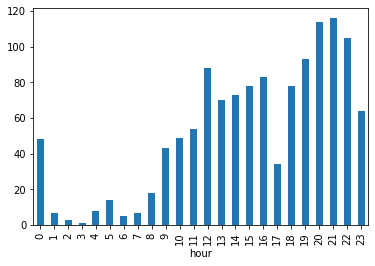

In [20]:
df[df['user']==me].groupby(['hour']).size().sort_index().plot(x="hour", kind='bar')

**Self Active Hrs on Group overall according to the msgs done**

## Q 4) 
## What is the difference in Weekend vs Weekday usage pattern?
## How many words do I type on average on weekday vs weekend?

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DatetimeIndex.weekday.html

In [21]:
df['weekday'] = df['date_time'].apply(lambda x: x.day_name()) # can use day_name or weekday from datetime 

In [22]:
df['is_weekend'] = df.weekday.isin(['Sunday', 'Saturday'])

In [ ]:
msgs_per_user = df['user'].value_counts(sort=True)
msgs_per_user

***Cleared Output***

In [ ]:
top5_users = msgs_per_user.index.tolist()[:5]
top5_users

***Cleared Output***

In [ ]:
df_top5 = df.copy()
df_top5 = df_top5[df_top5.user.isin(top5_users)]
df_top5.head()

***Cleared Output***

In [ ]:
plt.figure(figsize=(30,10))
sns.countplot(x="user", hue="weekday", data=df)

***Cleared Output***

In [27]:
df_top5['is_weekend'] = df_top5.weekday.isin(['Sunday', 'Saturday'])

In [ ]:
plt.figure(figsize=(20,10))
sns.countplot(x="user", hue="is_weekend", data=df_top5)

***Cleared Output***

In [29]:
def word_count(val):
    return len(val.split())

In [30]:
df['no_of_words'] = df['msg'].apply(word_count)

In [31]:
df_top5['no_of_words'] = df_top5['msg'].apply(word_count)

In [32]:
total_words_weekday = df[df['is_weekend']==False]['no_of_words'].sum()
total_words_weekday

204986

In [33]:
total_words_weekend = df[df['is_weekend']]['no_of_words'].sum()
total_words_weekend

91483

In [34]:
total_words_weekday/5 # average words on a weekday

40997.2

In [35]:
total_words_weekend/2 # average words on a weekend

45741.5

In [ ]:
df.groupby('user')['no_of_words'].sum().sort_values(ascending=False)

***Cleared Output***

In [ ]:
(df_top5.groupby('user')['no_of_words'].sum()/df_top5.groupby('user').size()).sort_values(ascending=False)

***Cleared Output***

In [ ]:
wordPerMsg_weekday_vs_weekend = (df_top5.groupby(['user', 'is_weekend'])['no_of_words'].sum()/df_top5.groupby(['user', 'is_weekend']).size())
wordPerMsg_weekday_vs_weekend

***Cleared Output***

In [ ]:
wordPerMsg_weekday_vs_weekend.plot(kind='barh')

***Cleared Output***

## Q 5)
## Most Usage - Time of Day

In [40]:
x = df.groupby(['hour', 'weekday'])['msg'].size().reset_index()
x2 = x.pivot("hour", 'weekday', 'msg')
x2.head()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
hour,,,,,,,
0,310,201,234,223,185,269,134
1,103,183,138,170,172,76,107
2,64,71,34,67,94,52,7
3,56,30,13,26,58,15,13
4,28,57,18,7,40,14,2


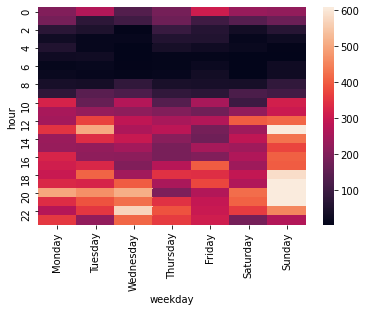

In [41]:
days = ["Monday", 'Tuesday', "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
sns.heatmap(x2[days].fillna(0), robust=True)

## Q 6) In any group, do I have any inclination towards responding to someone? 

In [42]:
my_msgs_index = np.array(df[df['user']==me].index)
print(my_msgs_index, my_msgs_index.shape)

[   14    16    25 ... 36556 36578 36584] (1253,)


In [43]:
prev_msgs_index = my_msgs_index - 1
print(prev_msgs_index, prev_msgs_index.shape)

[   13    15    24 ... 36555 36577 36583] (1253,)


In [44]:
df_replies = df.iloc[prev_msgs_index].copy()
df_replies.shape

(1253, 7)

In [ ]:
df_replies.groupby(["user"])["msg"].size().sort_values().plot(kind='barh')

***Cleared Output Very interesting graph shows to whom you respond very often***

## Q 7) Which are the most common words?

In [46]:
comment_words = ' '
stopwords = STOPWORDS.update(['lo', 'ge', 'Lo', 'illa', 'yea', 'ella', 'en', 'na', 'En', 'yeah', 'alli', 'ide', 'okay', 'ok', 'will'])
  
for val in df.msg.values: 
    val = str(val) 
    tokens = val.split() 
        
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 


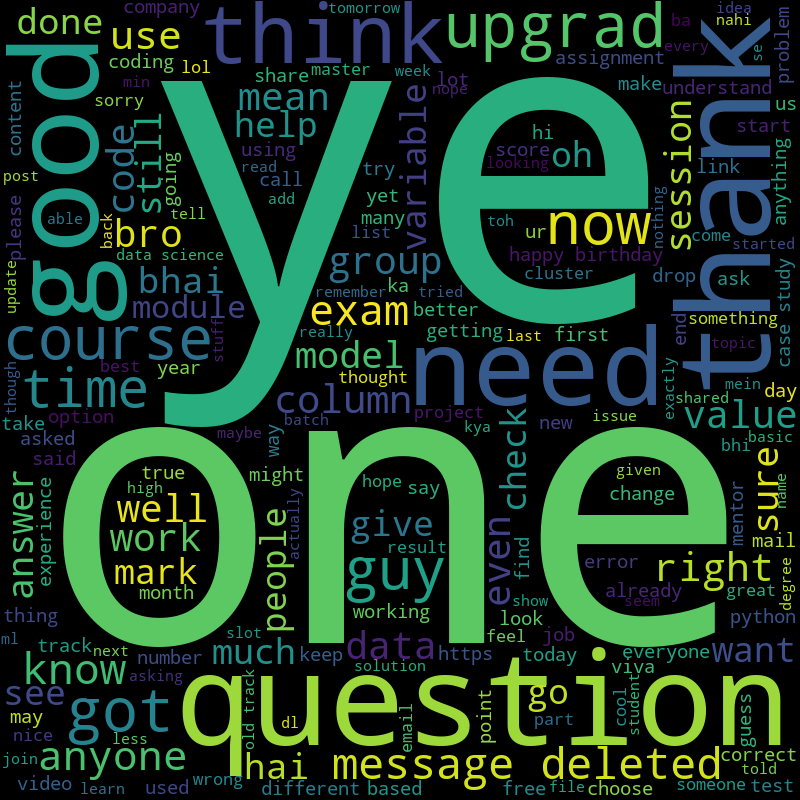

In [47]:
wordcloud.to_image()